# Project Implementation

In [1]:
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import datetime
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
import matplotlib.patches as mpatches
from sklearn.tree import DecisionTreeRegressor

In [2]:
#Load the cleaned data set
data = pd.read_csv('Data/new_autos_dropped.csv', sep=',',encoding='ISO-8859-1')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202407 entries, 0 to 202406
Data columns (total 11 columns):
Unnamed: 0      202407 non-null int64
price           202407 non-null int64
vehicle_type    202407 non-null object
gearbox         202407 non-null object
power_ps        202407 non-null int64
model           202407 non-null object
kilometer       202407 non-null int64
fuel_type       202407 non-null object
brand           202407 non-null object
postal_code     202407 non-null int64
vehicleAge      202407 non-null int64
dtypes: int64(6), object(5)
memory usage: 17.0+ MB


In [4]:
data.head()

,Unnamed: 0,price,vehicle_type,gearbox,power_ps,model,kilometer,fuel_type,brand,postal_code,vehicleAge
0,3,1500,kleinwagen,manuell,75,golf,150000,benzin,volkswagen,91074,225
1,4,3600,kleinwagen,manuell,69,fabia,90000,diesel,skoda,60437,140
2,6,2200,cabrio,manuell,109,2_reihe,150000,benzin,peugeot,67112,187
3,10,2000,limousine,manuell,105,3_reihe,150000,benzin,mazda,96224,183
4,14,17999,suv,manuell,190,navara,70000,diesel,nissan,4177,108


In [5]:
#Dropping Columns "Unnamed:0" and "postal_code"
data = data.drop('Unnamed: 0',1)
data = data.drop('postal_code',1)

In [6]:
#Making a copy the dataframe
new_autos = data.copy()

In [7]:
#Encoding the columns with character data
from sklearn.preprocessing import LabelEncoder
le= LabelEncoder()
cat = new_autos.columns[new_autos.dtypes==object]
for col in cat:
    new_autos[col]= le.fit_transform(new_autos[col])
new_autos.head()

,price,vehicle_type,gearbox,power_ps,model,kilometer,fuel_type,brand,vehicleAge
0,1500,3,1,75,116,150000,0,37,225
1,3600,3,1,69,101,90000,2,31,140
2,2200,1,1,109,7,150000,0,25,187
3,2000,5,1,105,9,150000,0,19,183
4,17999,6,1,190,159,70000,2,23,108


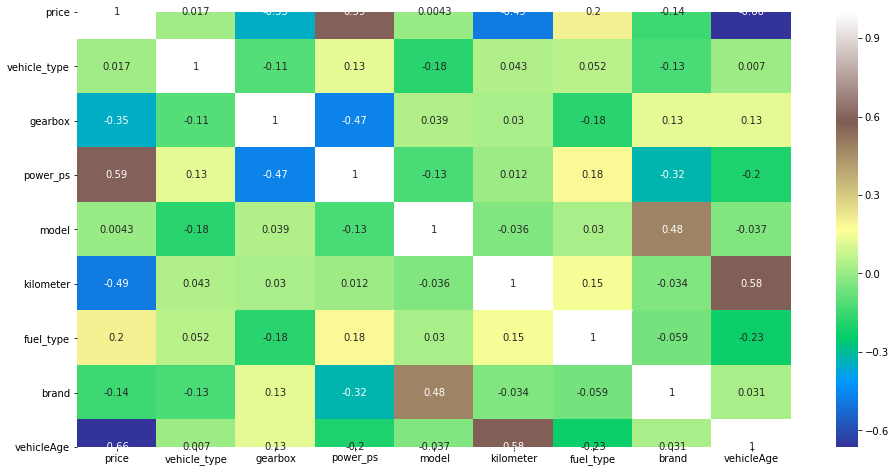

In [8]:
#Plot the heatmap for visualizing the correlation between attributes
plt.figure(figsize=(16,8))
sns.heatmap(new_autos.corr(), annot=True,cmap="terrain", )

In [9]:
sample_data = new_autos.sample(frac=0.01, replace=True)
y=sample_data['price']
X=sample_data.drop(['price'], axis=1)
X.shape, y.shape

((2024, 8), (2024,))

In [10]:
#GridSearchCV 
from sklearn.model_selection import GridSearchCV
def gridsearchcv(model,parameters):
    gsCV = GridSearchCV(model,parameters,n_jobs=-1, verbose=1)  
    return gsCV  

In [11]:
#GridSearchCV 
from sklearn.model_selection import GridSearchCV
gsCV_model = RandomForestRegressor(oob_score=True)
tuned_parameters = {'n_estimators': [200],
                    'max_features':[2,4,8, 'auto'],
                    'max_depth':[10,20],
                    'min_samples_split':[2,3,4,],
                    'min_samples_leaf':[1,2,3]}
gsCV = gridsearchcv(gsCV_model, tuned_parameters)  
gsCV.fit(X,y)

Fitting 3 folds for each of 72 candidates, totalling 216 fits


/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   29.1s
[Parallel(n_jobs=-1)]: Done 216 out of 216 | elapsed:   35.3s finished


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=True, random_state=None,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'max_depth': [10, 20],
      

In [12]:
print(gsCV.best_score_)
print(gsCV.best_params_)

0.825704753267242
{'max_depth': 10, 'max_features': 4, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


In [13]:
from collections import OrderedDict
from sklearn.datasets import make_classification
ensemble_clfs = [("RandomForestRegressor, max_depth='20', min_samples_split='3', min_samples_leaf='1'",
                  RandomForestRegressor(warm_start=True, max_features=4, max_depth=20, min_samples_split=3, min_samples_leaf=1,oob_score=True))]
error_rate = OrderedDict((label, []) for label, _ in ensemble_clfs)


min_estimators = 30
max_estimators = 1000

for label, clf in ensemble_clfs:
    for i in range(min_estimators, max_estimators + 1, 50):
        clf.set_params(n_estimators=i)
        clf.fit(X, y)
        
        oob_error = 1 - clf.oob_score_
        error_rate[label].append((i, oob_error))

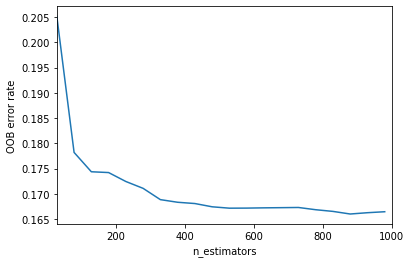

In [14]:
# Generating "OOB error rate" vs. "n_estimators" plot.
for label, clf_err in error_rate.items():
    xs, ys = zip(*clf_err)
    plt.plot(xs, ys, label=label)
plt.xlim(min_estimators, max_estimators)
plt.xlabel("n_estimators")
plt.ylabel("OOB error rate")
plt.show()

### Build train and test data

In [15]:
X=new_autos.drop(['price'], axis=1)
y=new_autos['price']

In [16]:
#splitting to test and train set..
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)

#format
X_train.shape,y_train.shape,X_test.shape, y_test.shape

((161925, 8), (161925,), (40482, 8), (40482,))

## Linear Regression

In [17]:
#X_train, X_test, y_train, y_test
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [18]:
Linear_pred = linear_model.predict(X_test)

In [19]:
print("Linear Regression Mean Absolute Error:")
print(mean_absolute_error(y_test, Linear_pred))
print("Linear Regression Accuracy:")
print(linear_model.score(X_test, y_test))

Linear Regression Mean Absolute Error:
2777.0450934328337
Linear Regression Accuracy:
0.7113434436450036


#### Plot Real Price vs Estimated Price

In [20]:
test = new_autos[new_autos['brand']==31] #31 = skoda
sample_test = test.sample(frac=0.006, replace=True)
y_tp=sample_test['price']
X_tp=sample_test.drop(['price'], axis=1)
x_input = range(X_tp.shape[0])

In [21]:
X_tp.shape, y_tp.shape

((24, 8), (24,))

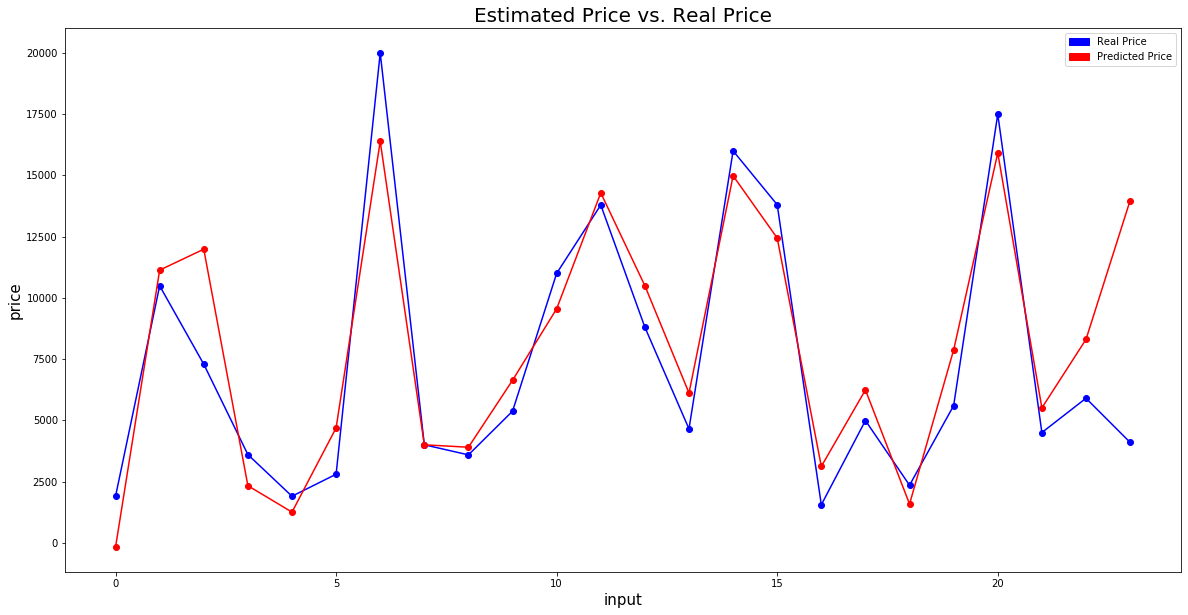

In [22]:
lin_pred= linear_model.predict(X_tp)
fig = plt.figure(figsize=(20,10))
plt.title("Estimated Price vs. Real Price",fontsize=20)
plt.xlabel("input", fontsize=15)
plt.ylabel("price", fontsize=15)

plt.plot(x_input,y_tp,marker='o',color='blue')
blue_patch = mpatches.Patch(color='blue', label= 'Real Price')

plt.plot(x_input,lin_pred,marker='o',color='red')
red_patch = mpatches.Patch(color='red', label= 'Predicted Price')

plt.legend(handles=[blue_patch,red_patch])
plt.show()

## K-Nearest Neighbors

In [23]:
#GridSearchCV 
KNCV_model = KNeighborsRegressor()
tuned_parameters = {'n_neighbors': [3,5,11,19],
                    'weights':['uniform'],
                    'metric':['euclidean','manhattan']}


In [24]:
gsCV = gridsearchcv(KNCV_model,tuned_parameters)
gsCV.fit(X,y)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:  1.2min finished


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30,
                                           metric='minkowski',
                                           metric_params=None, n_jobs=None,
                                           n_neighbors=5, p=2,
                                           weights='uniform'),
             iid='warn', n_jobs=-1,
             param_grid={'metric': ['euclidean', 'manhattan'],
                         'n_neighbors': [3, 5, 11, 19],
                         'weights': ['uniform']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=1)

In [25]:
print(gsCV.best_score_)
print(gsCV.best_params_)

0.8917606815425574
{'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'uniform'}


In [26]:
neigh = KNeighborsRegressor(n_neighbors=2, weights = 'uniform')
neigh.fit(X_train, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                    weights='uniform')

In [27]:
knn_pred = neigh.predict(X_test)

In [28]:
print("KNN Mean Absolute Error:")
print(mean_absolute_error(y_test, knn_pred))
print("KNN Accuracy:")
print(neigh.score(X_test,y_test))

KNN Mean Absolute Error:
1416.9421100736129
KNN Accuracy:
0.8814787014572627


#### Plot Real Price vs Estimated Price

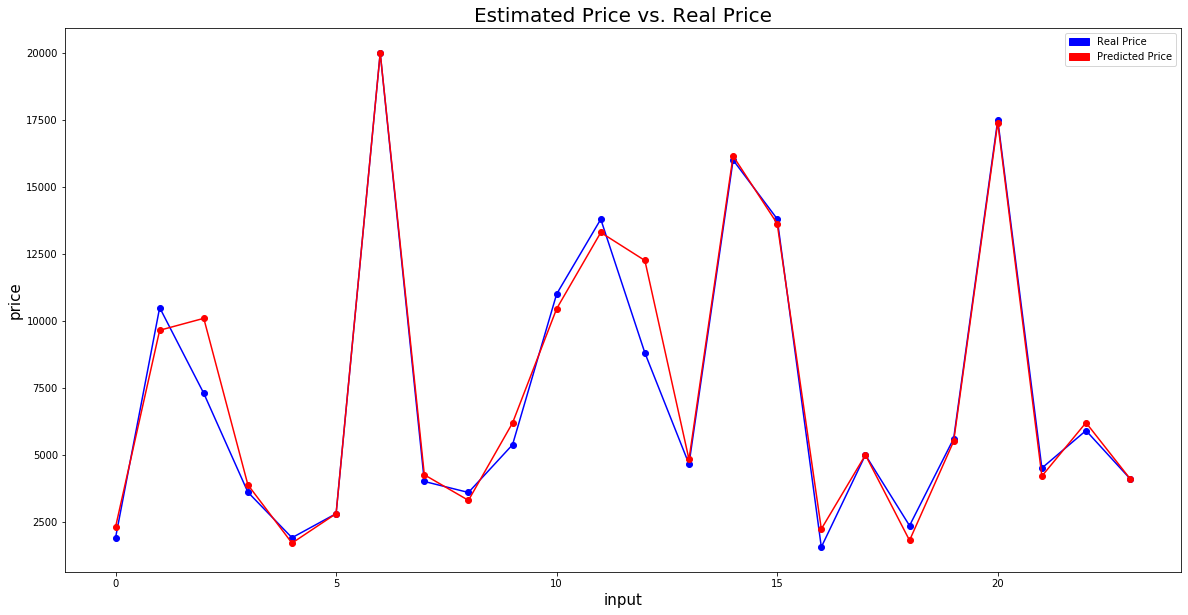

In [29]:
knnei_pred= neigh.predict(X_tp)
fig = plt.figure(figsize=(20,10))
plt.title("Estimated Price vs. Real Price",fontsize=20)
plt.xlabel("input", fontsize=15)
plt.ylabel("price", fontsize=15)

plt.plot(x_input,y_tp,marker='o',color='blue')
blue_patch = mpatches.Patch(color='blue', label= 'Real Price')

plt.plot(x_input,knnei_pred,marker='o',color='red')
red_patch = mpatches.Patch(color='red', label= 'Predicted Price')

plt.legend(handles=[blue_patch,red_patch])
plt.show()

## Neural networks

In [30]:
nn_model = MLPRegressor(hidden_layer_sizes=(128,), # Pretty much a random value here to start playing with
                        max_iter=150, # Some base line
                        verbose=True, # Well, I am just too eager :)
                        random_state=42, # We want repeatable experiments
                        alpha=0.7 #  No regularization by default... IF we have overfitting, then we will look into it
                       )
nn_model.fit(X_train, y_train)

Iteration 1, loss = 36270795.96175373
Iteration 2, loss = 23904179.08328530
Iteration 3, loss = 13989781.49860650
Iteration 4, loss = 11254273.56017405
Iteration 5, loss = 10745310.27814998
Iteration 6, loss = 10472826.61632020
Iteration 7, loss = 10124236.60625307
Iteration 8, loss = 9830607.52587562
Iteration 9, loss = 9595054.27520884
Iteration 10, loss = 9485042.62499576
Iteration 11, loss = 9344845.06093437
Iteration 12, loss = 9280382.62578297
Iteration 13, loss = 9149118.22865290
Iteration 14, loss = 9027984.83979518
Iteration 15, loss = 8930637.62932337
Iteration 16, loss = 8898258.04562528
Iteration 17, loss = 8839056.69517854
Iteration 18, loss = 8694951.52036259
Iteration 19, loss = 8635682.80124523
Iteration 20, loss = 8589123.47267590
Iteration 21, loss = 8528534.37702216
Iteration 22, loss = 8486292.56352979
Iteration 23, loss = 8462743.95135403
Iteration 24, loss = 8383401.14101298
Iteration 25, loss = 8330169.82632606
Iteration 26, loss = 8298742.37614237
Iteration 27, 

/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPRegressor(activation='relu', alpha=0.7, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=(128,), learning_rate='constant',
             learning_rate_init=0.001, max_iter=150, momentum=0.9,
             n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
             random_state=42, shuffle=True, solver='adam', tol=0.0001,
             validation_fraction=0.1, verbose=True, warm_start=False)

In [31]:
nn_pred = nn_model.predict(X_test)

In [32]:
print("Neural Network Mean Absolute Error:")
print(mean_absolute_error(y_test, nn_pred))
print("Neural Network Accuracy:")
print(nn_model.score(X_test, y_test))

Neural Network Mean Absolute Error:
2242.498337845975
Neural Network Accuracy:
0.7703617684786244


#### Plot Real Price vs Estimated Price

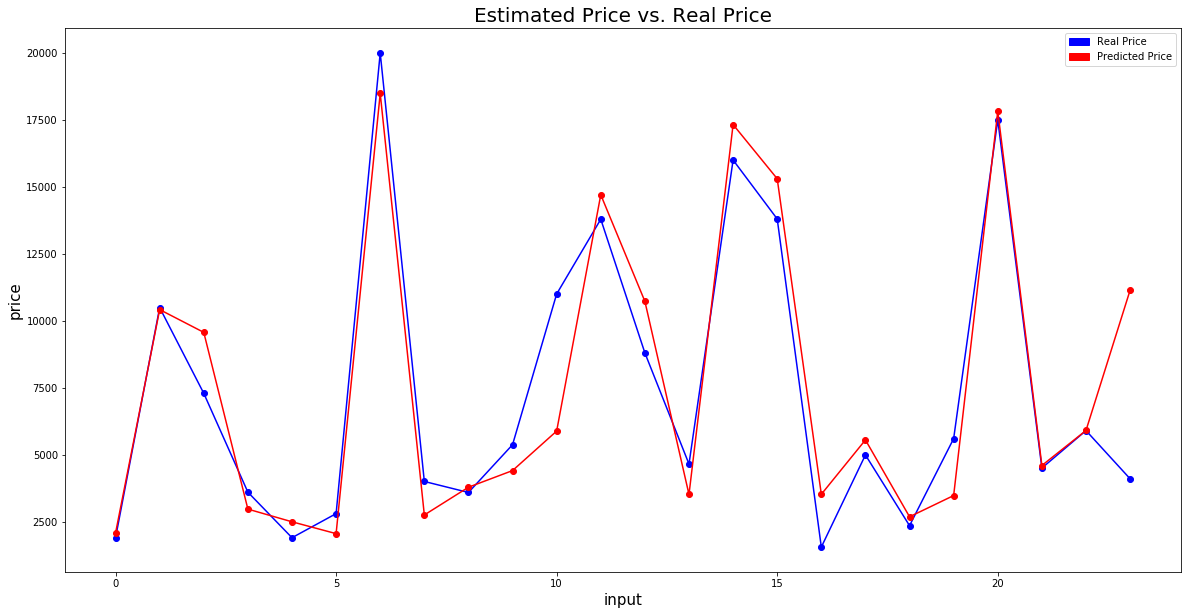

In [33]:
nni_pred= nn_model.predict(X_tp)
fig = plt.figure(figsize=(20,10))
plt.title("Estimated Price vs. Real Price",fontsize=20)
plt.xlabel("input", fontsize=15)
plt.ylabel("price", fontsize=15)

plt.plot(x_input,y_tp,marker='o',color='blue')
blue_patch = mpatches.Patch(color='blue', label= 'Real Price')

plt.plot(x_input,nni_pred,marker='o',color='red')
red_patch = mpatches.Patch(color='red', label= 'Predicted Price')

plt.legend(handles=[blue_patch,red_patch])
plt.show()

## Decision Tree

In [34]:
from sklearn.pipeline import make_pipeline
from sklearn.metrics import make_scorer

depths = np.arange(1, 21)
num_leafs = [1, 5, 10, 20, 50, 100]
param_grid = [{'decisiontreeregressor__max_depth':depths,
              'decisiontreeregressor__min_samples_leaf':num_leafs}]
pipe_tree = make_pipeline(DecisionTreeRegressor(random_state=1))

In [35]:
gsCV = gridsearchcv(pipe_tree, param_grid)

In [36]:
gsCV.fit(X,y)


/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 120 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 263 tasks      | elapsed:   18.0s
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:   29.6s finished


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('decisiontreeregressor',
                                        DecisionTreeRegressor(criterion='mse',
                                                              max_depth=None,
                                                              max_features=None,
                                                              max_leaf_nodes=None,
                                                              min_impurity_decrease=0.0,
                                                              min_impurity_split=None,
                                                              min_samples_leaf=1,
                                                              min_samples_split=2,
                                                              min_weight_fraction_leaf=0.0,
                                                              presort=False,
  

In [37]:
print(gsCV.best_score_)
print(gsCV.best_params_)

0.8989424387150268
{'decisiontreeregressor__max_depth': 18, 'decisiontreeregressor__min_samples_leaf': 5}


In [38]:
regr_1 = DecisionTreeRegressor(max_depth=10)
regr_1.fit(X_train,y_train)

DecisionTreeRegressor(criterion='mse', max_depth=10, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

In [39]:
Decision_pred= regr_1.predict(X_test)

In [40]:
print("Decision Tree Mean Absolute Error:")
print(mean_absolute_error(y_test, Decision_pred))
print("Decision Tree  Accuracy:")
print(regr_1.score(X_test,y_test))

Decision Tree Mean Absolute Error:
1581.5861076779113
Decision Tree  Accuracy:
0.8755958046496239


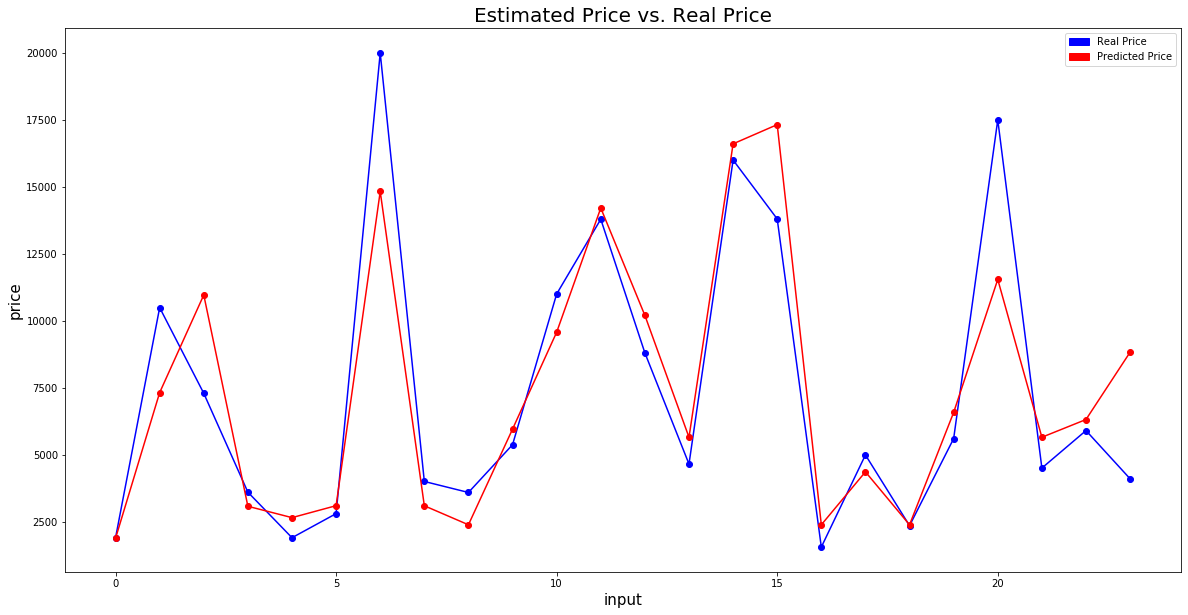

In [41]:
dec_pred= regr_1.predict(X_tp)
fig = plt.figure(figsize=(20,10))
plt.title("Estimated Price vs. Real Price",fontsize=20)
plt.xlabel("input", fontsize=15)
plt.ylabel("price", fontsize=15)

plt.plot(x_input,y_tp,marker='o',color='blue')
blue_patch = mpatches.Patch(color='blue', label= 'Real Price')

plt.plot(x_input,dec_pred,marker='o',color='red')
red_patch = mpatches.Patch(color='red', label= 'Predicted Price')

plt.legend(handles=[blue_patch,red_patch])
plt.show()

## Random Forest

#### Plot Real Price vs Estimated Price

In [42]:
model=RandomForestRegressor(max_features = 4, max_depth= 20, min_samples_leaf= 1, oob_score=True,
                            min_samples_split= 3, n_estimators= 500,
                            n_jobs=-1)
model.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=20,
                      max_features=4, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=3,
                      min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
                      oob_score=True, random_state=None, verbose=0,
                      warm_start=False)

In [43]:
forest_pred= model.predict(X_test)

In [44]:
print("Random Forest Mean Absolute Error:")
print(mean_absolute_error(y_test, forest_pred))
print("Random Forest Accuracy:")
print(model.score(X_test,y_test))

Random Forest Mean Absolute Error:
1111.1638705887335
Random Forest Accuracy:
0.9340572302022464


#### Plot Real Price vs Estimated Price

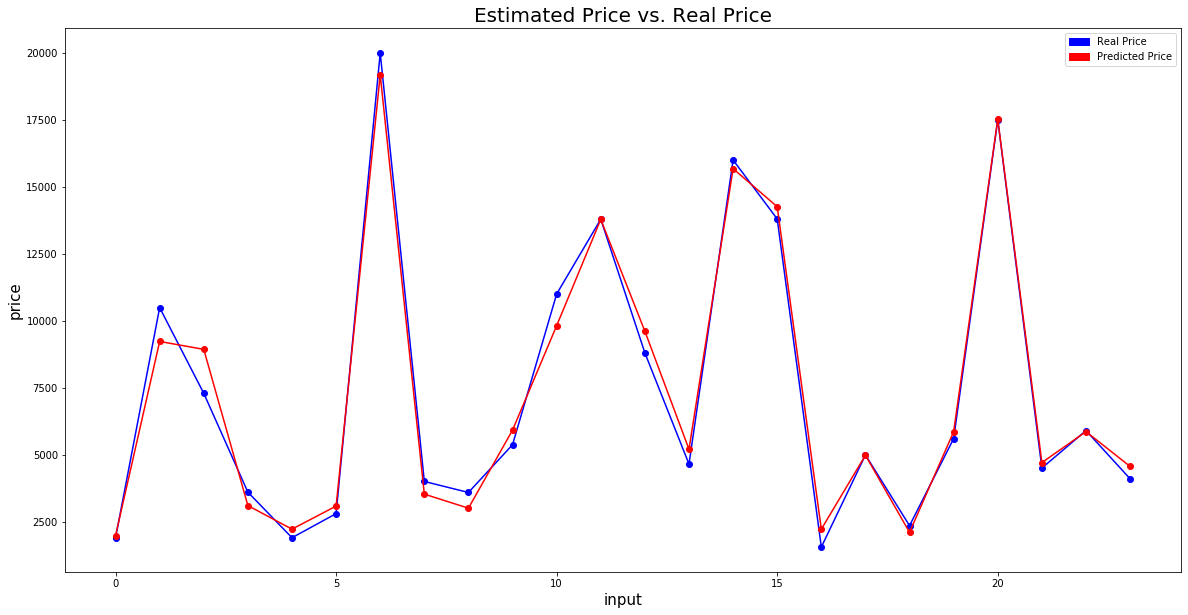

In [45]:
rf_pred= model.predict(X_tp)
fig = plt.figure(figsize=(20,10))
plt.title("Estimated Price vs. Real Price",fontsize=20)
plt.xlabel("input", fontsize=15)
plt.ylabel("price", fontsize=15)

plt.plot(x_input,y_tp,marker='o',color='blue')
blue_patch = mpatches.Patch(color='blue', label= 'Real Price')

plt.plot(x_input,rf_pred,marker='o',color='red')
red_patch = mpatches.Patch(color='red', label= 'Predicted Price')

plt.legend(handles=[blue_patch,red_patch])
plt.show()

#### Comparision between all above models

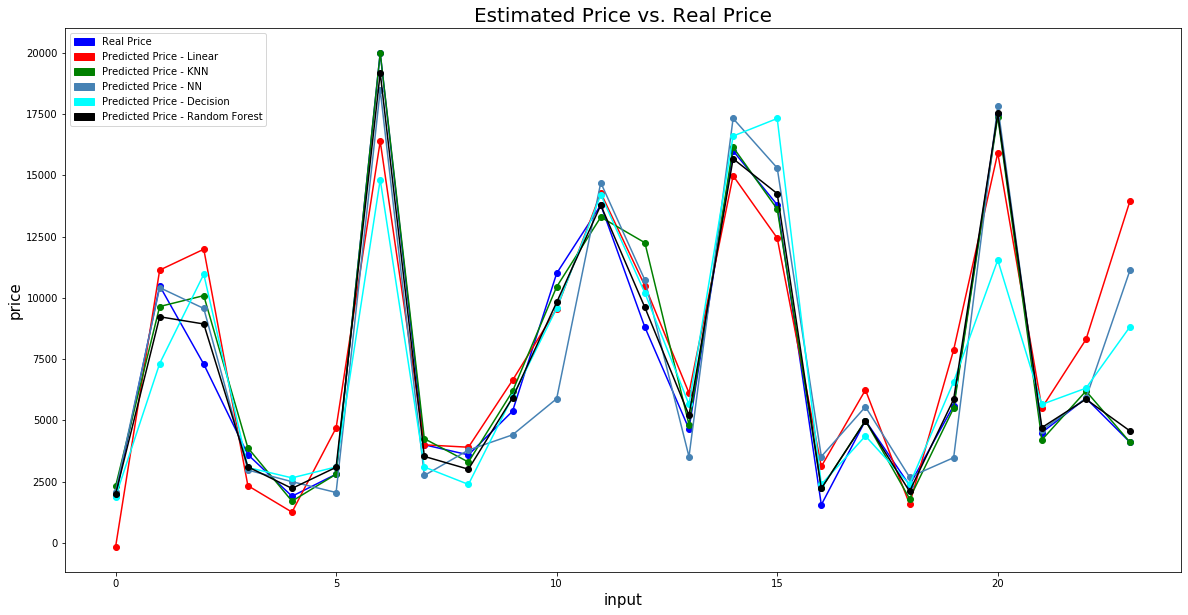

In [46]:
fig = plt.figure(figsize=(20,10))
plt.title("Estimated Price vs. Real Price",fontsize=20)
plt.xlabel("input", fontsize=15)
plt.ylabel("price", fontsize=15)
plt.plot(x_input,y_tp,marker='o',color='blue')
blue_patch = mpatches.Patch(color='blue', label= 'Real Price')

plt.plot(x_input,lin_pred,marker='o',color='red')
red_patch = mpatches.Patch(color='red', label= 'Predicted Price - Linear')

plt.plot(x_input,knnei_pred,marker='o',color='green')
green_patch = mpatches.Patch(color='green', label= 'Predicted Price - KNN')

plt.plot(x_input,nni_pred,marker='o',color='steelblue')
steelblue_patch = mpatches.Patch(color='steelblue', label= 'Predicted Price - NN')

plt.plot(x_input,dec_pred,marker='o',color='cyan')
cyan_patch = mpatches.Patch(color='cyan', label= 'Predicted Price - Decision')

plt.plot(x_input,rf_pred,marker='o',color='black')
black_patch = mpatches.Patch(color='black', label= 'Predicted Price - Random Forest')

plt.legend(handles=[blue_patch,red_patch,green_patch,steelblue_patch,cyan_patch,black_patch])
plt.show()

### Important features

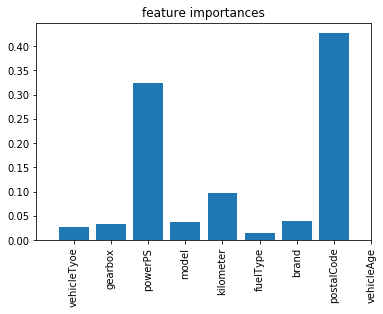

In [47]:
plt.figure()
plt.title("feature importances")
plt.bar(range(X.shape[1]), model.feature_importances_, align="center")
plt.xticks(range(9), ('vehicleTyoe', 'gearbox', 'powerPS', 'model', 'kilometer', 'fuelType', 'brand', 'postalCode', 'vehicleAge'), rotation=90 )
plt.xlim([-1, X.shape[1]])
plt.show()

In [48]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
Regressors = [("linear_regression", linear_model),
               ("Kneighbor", KNCV_model), 
               ("MLP Regressor", nn_model), 
               ("Decision Tree", regr_1), 
               ("Random Forest", model)]

 

for name, regressor in Regressors:
    regressor.fit(X_train, y_train)
    predictions = regressor.predict(X_test)

 

    print("For "+ name +", mean square error and mean absolute error were:")
    print(mean_squared_error(y_test,predictions))
    print(mean_absolute_error(y_test,predictions))
    print("")

For linear_regression, mean square error and mean absolute error were:
16317176.209570393
2777.0450934328337

For Kneighbor, mean square error and mean absolute error were:
6473519.171704955
1413.2903809100342

Iteration 1, loss = 36270795.96175373
Iteration 2, loss = 23904179.08328530
Iteration 3, loss = 13989781.49860650
Iteration 4, loss = 11254273.56017405
Iteration 5, loss = 10745310.27814998
Iteration 6, loss = 10472826.61632020
Iteration 7, loss = 10124236.60625307
Iteration 8, loss = 9830607.52587562
Iteration 9, loss = 9595054.27520884
Iteration 10, loss = 9485042.62499576
Iteration 11, loss = 9344845.06093437
Iteration 12, loss = 9280382.62578297
Iteration 13, loss = 9149118.22865290
Iteration 14, loss = 9027984.83979518
Iteration 15, loss = 8930637.62932337
Iteration 16, loss = 8898258.04562528
Iteration 17, loss = 8839056.69517854
Iteration 18, loss = 8694951.52036259
Iteration 19, loss = 8635682.80124523
Iteration 20, loss = 8589123.47267590
Iteration 21, loss = 8528534.37

/opt/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


For Decision Tree, mean square error and mean absolute error were:
7076808.319935853
1582.739290527652

For Random Forest, mean square error and mean absolute error were:
3736394.8794298163
1112.35865056185

